# Target Trial Emulation with Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
import pytrialemulation as te
import os

In [2]:
# --- Load Data and Preprocess (Baseline Only) ---
def load_and_preprocess(file_path, feature_cols):
    # Load full data
    df = pd.read_csv(file_path)
    # Keep only the first record per patient (baseline)
    df_baseline = df.drop_duplicates(subset="id", keep="first").copy()
    # Select only the fixed characteristics (baseline covariates)
    features = df_baseline[feature_cols]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    return df_baseline, scaled_features

# --- Determine Optimal Number of Clusters using KMeans ---
def optimal_kmeans(scaled_features):
    best_k, best_score = 2, -1
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(scaled_features)
        score = silhouette_score(scaled_features, labels)
        if score > best_score:
            best_k, best_score = k, score
    return best_k

# --- Perform Clustering (all methods) ---
def cluster_data(scaled_features, best_k):
    # KMeans clustering
    kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(scaled_features)
    
    # DBSCAN clustering
    dbscan = DBSCAN(eps=1, min_samples=5)
    dbscan_labels = dbscan.fit_predict(scaled_features)
    
    # Hierarchical clustering
    linkage_matrix = linkage(scaled_features, method='ward')
    hierarchical_labels = fcluster(linkage_matrix, t=best_k, criterion='maxclust')
    
    return kmeans_labels, dbscan_labels, hierarchical_labels

# Step 1. Clustering the Dataset

In this step, we clustered the dataset based on the values of ```x3```, ```x4```, and ```age```. The reason why we chose these columns as features is because, these values are fixed for every patient i.e. they don't change, unlike the other columns which are covariates, which means they change over time.

Baseline row count: 89
Optimal number of clusters (KMeans): 6


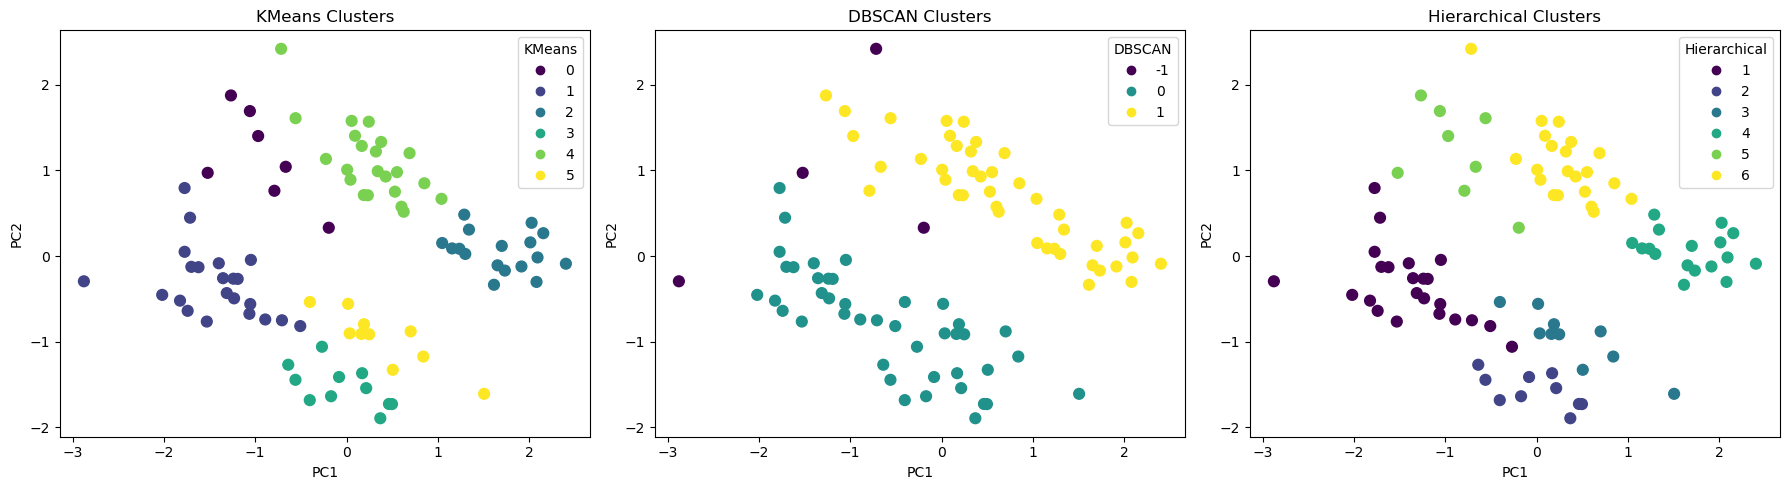

In [3]:
# --- Load Data and Preprocess ---
file_path = 'data_censored.csv'  # Update with your file path if needed
# We use the fixed characteristics: x3, x4, and age
feature_cols = ['x3', 'x4', 'age']
df_baseline, scaled_features = load_and_preprocess(file_path, feature_cols)

print("Baseline row count:", df_baseline.shape[0])

# --- Determine Optimal Number of Clusters using KMeans ---
best_k = optimal_kmeans(scaled_features)
print("Optimal number of clusters (KMeans):", best_k)

# --- Perform Clustering using all three methods ---
kmeans_labels, dbscan_labels, hierarchical_labels = cluster_data(scaled_features, best_k)

# --- Add the cluster labels to the original baseline dataframe ---
df_baseline['kmeans_cluster'] = kmeans_labels
df_baseline['dbscan_cluster'] = dbscan_labels
df_baseline['hierarchical_cluster'] = hierarchical_labels

# --- Perform PCA on the scaled features ---
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(scaled_features)
df_baseline['PC1'] = pca_components[:, 0]
df_baseline['PC2'] = pca_components[:, 1]

# --- Plot the Clusters for each method in subplots ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
clustering_methods = [
    ('KMeans', 'kmeans_cluster'),
    ('DBSCAN', 'dbscan_cluster'),
    ('Hierarchical', 'hierarchical_cluster')
]

for ax, (method_name, label_col) in zip(axs, clustering_methods):
    scatter = ax.scatter(df_baseline['PC1'], df_baseline['PC2'], c=df_baseline[label_col], cmap='viridis', s=60)
    ax.set_title(f'{method_name} Clusters')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    # Add legend based on unique cluster labels
    handles, _ = scatter.legend_elements()
    unique_labels = [str(int(label)) for label in np.unique(df_baseline[label_col])]
    ax.legend(handles, unique_labels, title=method_name)
    
plt.tight_layout()
plt.show()

(will decide pa on what cluster)

In [4]:
df_baseline.head()

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,kmeans_cluster,dbscan_cluster,hierarchical_cluster,PC1,PC2
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,5,0,3,0.034592,-0.902189
6,2,0,0,1,-0.802142,0,-0.990794,26,-0.750000,0,0,1,3,0,2,-0.559564,-1.444481
11,3,0,1,0,0.571029,1,0.391966,48,1.083333,0,0,1,4,1,6,0.092442,1.404823
19,4,0,0,0,-0.107079,1,-1.613258,29,-0.500000,0,0,1,0,-1,5,-0.194659,0.331136
23,5,0,1,1,0.749092,0,1.620330,32,-0.250000,0,0,1,5,0,3,0.839770,-1.172787


### Step 1.1 Assigning Clusters

During the previous step, we already assgined the clusters on the data per clustering algorithm. However, we will only have to choose one, and that is K-means clustering.

In [5]:
df_baseline['cluster'] = df_baseline['kmeans_cluster']
df_baseline = df_baseline[['id', 'cluster']].copy() # We only get the important columns

df = pd.read_csv(file_path)
df = df.merge(df_baseline[['id', 'cluster']], on='id', how='left')
df = df[df['cluster'] != -1].copy() # If DBSCAN, remove outliers
df.head()

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible,cluster
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1,5
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0,5
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0,5
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0,5
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0,5


# Step 2. Performing Target Trial Emulation

In [6]:
base_dir = os.path.join(os.getcwd(), "trial_itt_clusters")
os.makedirs(base_dir, exist_ok=True)

trial_results = {}

# Performing TTE per cluster
for cl in df['cluster'].unique():
    
    # Step 1. Initializing the object and setting the estimand
    trial_seq = te.TrialSequence(estimand="ITT")

    cluster_dir = os.path.join(base_dir, f"cluster_{cl}")
    os.makedirs(cluster_dir, exist_ok=True)
    

    # Step 2. Data Preparation
    cluster_data = df[df['cluster'] == cl].copy()
    trial_seq = trial_seq.set_data(
        data=cluster_data,
        Id="id",
        period="period",
        treatment="treatment",
        outcome="outcome",
        eligible="eligible"
    )
    

    # Step 3. Weight Censoring
    trial_seq = trial_seq.set_censor_weight_model(
        censor_event="censored",
        numerator="~ x2",
        denominator="~ x2 + x1",
        pool_models="numerator",
        model_fitter=te.StatsGLMLogit(save_path=cluster_dir),
    )
    

    # Step 4. Calculating Weights
    trial_seq.calculate_weights()
    

    # Step 5. Specifying Outcome Model
    trial_seq = te.set_outcome_model(
        trial_seq, 
        adjustment_terms="~ x2",
    )
    

    # Step 6. Expanding the trials and sequence of trials
    trial_seq = te.set_expansion_options(
        trial_seq,
        output=te.save_to_datatable(),
        chunk_size=500,
    )
    trial_seq = te.expand_trials(trial_seq)
    

    # Step 7. Load or Sample from Expanded Data
    trial_seq = te.load_expanded_data(trial_seq, seed = 1000, p_control = 0.5)
    

    # Step 8. Fit Marginal Model Structural Model
    trial_seq = te.fit_msm(
        trial_seq, 
        weight_cols=['weight', 'sample_weight'], 
        modify_weights=lambda w: np.minimum(w, np.quantile(w, 0.95))
    )

    # Storing the trial_results
    trial_results[cl] = trial_seq

# Step 3. Inference per Cluster

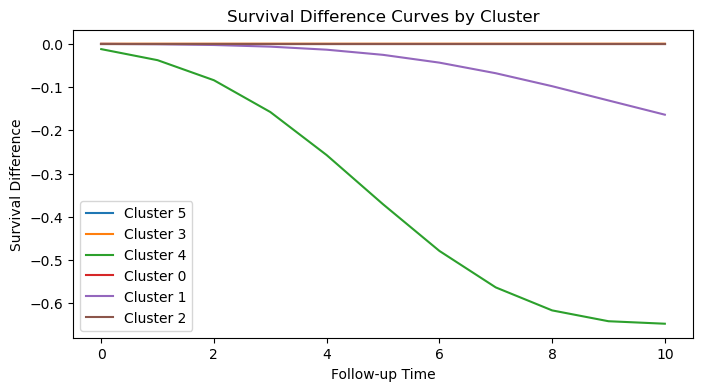

In [7]:
plt.figure(figsize=(8, 4))

for cl, trial_seq in trial_results.items():
    newdata = trial_seq.outcome_data.loc[trial_seq.outcome_data["trial_period"] == 1].copy()
    
    preds = te.predict_outcome(
        trial_seq=trial_seq,
        newdata=newdata,
        predict_times=list(range(0, 11)),  
        type_pred="survival"              
    )
    
    plt.plot(preds["difference"]["followup_time"], preds["difference"]["difference"],
             label=f"Cluster {cl}")

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.title("Survival Difference Curves by Cluster")
plt.legend()
plt.show()

# Step 4. Key Insights